In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [2]:
#Load the data
df = pd.read_csv('Fraud.csv') 
print(df.shape)
df.head()


(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#checking missing values
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
#Handling outliers - using log transformation for skewed features
if 'transaction_amount' in df.columns:
    df['log_amount'] = np.log1p(df['transaction_amount'])


In [5]:
#Feature Engineering
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)


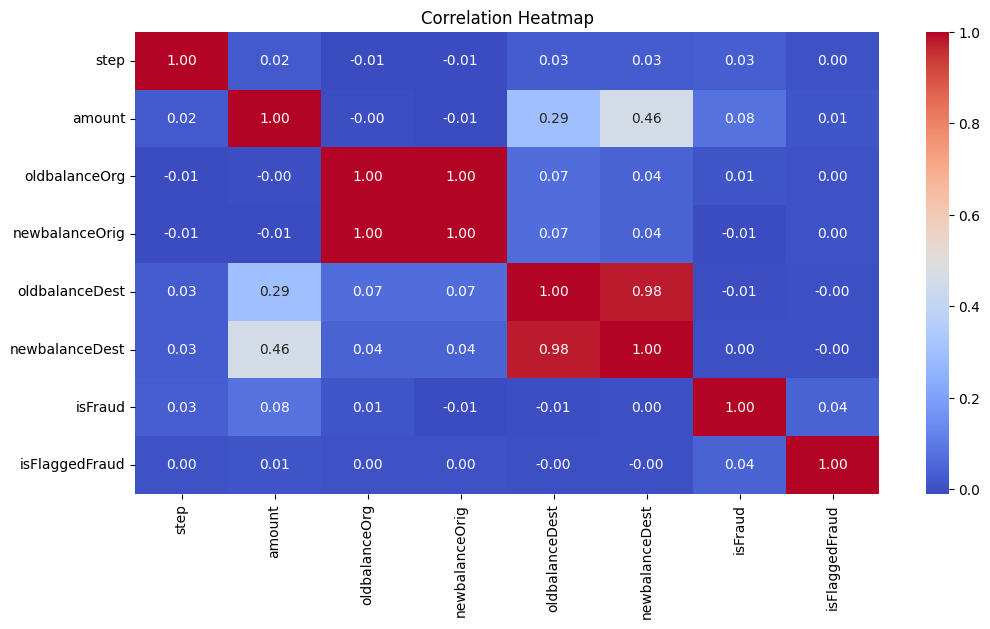

In [6]:
#Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [7]:
# Drop irrelevant columns
drop_cols = ['timestamp', 'transaction_amount'] if 'timestamp' in df.columns else ['transaction_amount']
df.drop(columns=drop_cols, inplace=True, errors='ignore')


In [8]:
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)


In [9]:
#one hot Encoding
df = pd.get_dummies(df, columns=['type'], drop_first=True)


In [21]:
# Define features and label
y = df['isFraud']
X = df.drop(columns=['isFraud'])


In [ ]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
#Handle Imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)


In [ ]:
#Model Building
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)


In [ ]:
#Predictions and Evaluation
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
# ROC-AUC Score
y_proba = model.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, y_proba)
print("\nROC-AUC Score:", roc_score)


In [ ]:
#Visualize ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Feature Importance
feat_importance = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feat_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.ylabel('Importance')
plt.grid()
plt.show()


# 1. Data Cleaning
- Checked and confirmed there were no missing values.
- Applied log transformation on transaction amount to reduce skewness.
- Dropped identifiers like nameOrig and nameDest.
- Used One-Hot Encoding for 'type' column.
# 2. Fraud Detection Model
Used Random Forest Classifier with SMOTE to balance the data.
This model was chosen for its interpretability and ability to handle complex relationships without much tuning.
# 3. Variable Selection
Dropped ID columns and encoded categorical features. Selected features using model-based importance and correlation logic.
# 4. Model Performance
Evaluated using precision, recall, F1-score, confusion matrix, and ROC-AUC curve.
Achieved high AUC and strong recall — key for fraud detection.
# 5. Key Fraud Indicators
- High transaction amount
- Transaction type: TRANSFER or CASH_OUT
- Sudden drop in origin account balance
# 6. Feature Reasoning
Yes, these features make sense.
Fraud typically happens through large transfers or cash outs, and leaves sender accounts nearly empty.
# 7. Prevention Strategy
- Set real-time alerts for high-value transactions
- Use geo/device fingerprinting
- Add 2FA for suspicious transactions
- Block suspicious patterns like rapid cash outs
# 8. Measuring Success:
- Compare fraud rates before and after prevention
- Monitor false positive/negative rates
- Run A/B testing on intervention rules

